In [1]:
list.of.packages <- c("ggplot2", "readr", "stringr", "magrittr", "logging")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]

# Install missing packages if any
if(length(new.packages) > 0) {
    install.packages(new.packages)
}

# Load packages
for(pkg in list.of.packages){
    library(pkg, character.only=TRUE)
}

# Make plots pretty
theme_set(theme_bw())

# Data Standardization

Let's use a random dataset in order to put in practice some of the data standardization techniques.

In [2]:
URL_ALBERTA = 'https://open.alberta.ca/dataset/a4b99aad-3f33-45ea-a5c7-e34a4733d336/resource/8e5d4548-fe1a-4f36-a690-3da56af197e6/download/cmhc_preliminary_total_housing_starts_csv_v83.0_2019-08-09.csv'
INTERESTING_COLUMNS = c('Ref_Date', 'Urban.Centre', 'Preliminary.Housing.Starts')

# Read in the DataFrame and use only specified columns
df_alberta <- read.csv(URL_ALBERTA)[, INTERESTING_COLUMNS]

# Fix the 'housing' column so that all rows contain integers
df_alberta$Preliminary.Housing.Starts <- as.numeric(as.character(df_alberta$Preliminary.Housing.Starts))
# df_alberta['Preliminary Housing Starts'] = df_alberta['Preliminary Housing Starts'].apply(cast_to_int)

# Print the dataframe details and first 5 rows
summary(df_alberta)
head(df_alberta)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

    Ref_Date                       Urban.Centre Preliminary.Housing.Starts
 10-Nov :  10   Calgary (CMA)            :151   Min.   :   1.0            
 07-Apr :   9   Edmonton (CMA)           :151   1st Qu.:  36.0            
 07-Aug :   9   Grande Prairie (CA)      :151   Median : 101.0            
 07-Dec :   9   Medicine Hat (CA)        :151   Mean   : 508.4            
 07-Feb :   9   Red Deer (CA)            :151   3rd Qu.: 789.0            
 07-Jan :   9   Seven Major Urban Centres:151   Max.   :4169.0            
 (Other):1304   (Other)                  :453   NA's   :6                 

Ref_Date,Urban.Centre,Preliminary.Housing.Starts
07-Jan,Calgary (CMA),800
07-Jan,Edmonton (CMA),1145
07-Jan,Red Deer (CA),211
07-Jan,Lethbridge (CA),71
07-Jan,Medicine Hat (CA),59
07-Jan,Wood Buffalo (CA),361


## Inconsistent Coding
In this example, let's take a look at the values for the `Urban Centre` attribute:

In [3]:
print('The unique values for cities are:')
print(unique(unlist(df_alberta['Urban.Centre'])))

[1] "The unique values for cities are:"
 [1] Calgary (CMA)             Edmonton (CMA)           
 [3] Red Deer (CA)             Lethbridge (CA)          
 [5] Medicine Hat (CA)         Wood Buffalo (CA)        
 [7] Grande Prairie (CA)       Five CAs                 
 [9] Seven Major Urban Centres Lethbridge (CMA)         
[11] Four CAs                 
11 Levels: Calgary (CMA) Edmonton (CMA) Five CAs ... Wood Buffalo (CA)


Now, *I don't know anything about Alberta urban centres*, so take everything here with a grain of salt.

But let's standardize this so that we have values that "mean something". We'll:
1. Rename the codes so they don't have the `(CMA)` and `(CA)` suffixes
2. Remove the rows for the aggregate values `'Five CAs'`, `'Seven Major Urban Centres'`, and `'Four CAs'`

### Rename codes
Here we use the [pandas string replace method](http://github.com/pandas-dev/pandas/blob/v0.25.0/pandas/core/strings.py#L2709-L2715) to detect the unwanted patterns and replace them with an empty string, `''`.

In [4]:
# Rename Urban Centre suffixes

suffixes = c(' \\(CMA\\)', ' \\(CA\\)')  # Escape parentheses with double backslashes

# Loop through the possible suffix values
for(suffix in suffixes){
#     unlist(df$Urban.Centre) %>% 
#         str_replace_all(unlist(df$Urban.Centre), suffix, "")
    df_alberta$Urban.Centre <- gsub(suffix, "", df_alberta$Urban.Centre)
}

print('The unique values for cities are:')
print(unique(unlist(df_alberta['Urban.Centre'])))

[1] "The unique values for cities are:"
 [1] "Calgary"                   "Edmonton"                 
 [3] "Red Deer"                  "Lethbridge"               
 [5] "Medicine Hat"              "Wood Buffalo"             
 [7] "Grande Prairie"            "Five CAs"                 
 [9] "Seven Major Urban Centres" "Four CAs"                 


In [5]:
# Remove the aggregate rows

aggregate_values = 'Five CAs|Seven Major Urban Centres|Four CAs'

# Overwrite the DataFrame only with the rows not in the aggregate rwos
# filter_all(grepl(aggregate_values, df_alberta$Urban.Centre))
df_alberta <- dplyr::filter(df_alberta, !grepl(aggregate_values, Urban.Centre))

# Show the difference
print('The unique values for cities are:')
print(unique(unlist(df_alberta['Urban.Centre'])))

[1] "The unique values for cities are:"
[1] "Calgary"        "Edmonton"       "Red Deer"       "Lethbridge"    
[5] "Medicine Hat"   "Wood Buffalo"   "Grande Prairie"


Now let's take a look at the first few entries again!

In [6]:
head(df_alberta)

Ref_Date,Urban.Centre,Preliminary.Housing.Starts
07-Jan,Calgary,800
07-Jan,Edmonton,1145
07-Jan,Red Deer,211
07-Jan,Lethbridge,71
07-Jan,Medicine Hat,59
07-Jan,Wood Buffalo,361


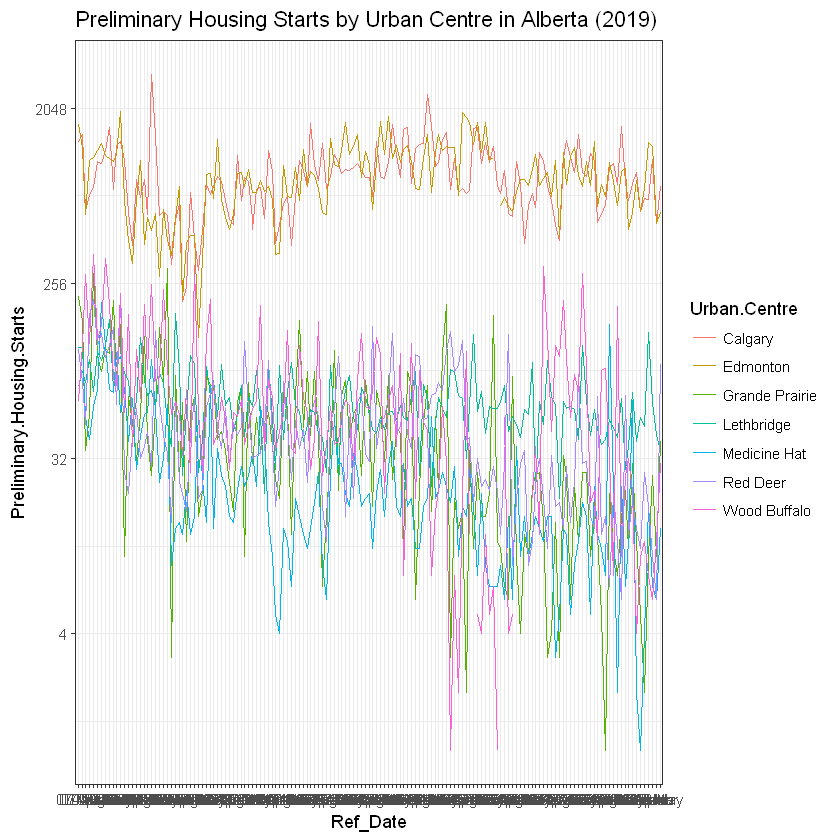

In [7]:
ggplot(data=df_alberta,
       aes(x = Ref_Date,
           y = Preliminary.Housing.Starts,
           colour = Urban.Centre,
           group=Urban.Centre)) +
    ggtitle("Preliminary Housing Starts by Urban Centre in Alberta (2019)") +
    geom_line() +
    scale_y_continuous(trans = 'log2')

Much better!

## Invalid Values

Here we'll use a mock dataset in order to illustrate some points.

For the sake of argument, let's imagine that in our use case, invalid values that go through our data processinng pipeline will break downstream applications &mdash; say, a dashboard that's refreshed every time new data comes in.

In [8]:
N <- 9
df_invalid <- structure(list(
             id = 1:N,
             group = c('A', 'A', 'B', 'B', 'Z', 'A', 'B', 'A', 'B'),
             location = c('Ottawa', 'Montréal', 'Ottawa', 'Red Deer', 'Ottawa', 'unknown', 'Toronto', 'Ottawa', 'Vancouver'),
             sales = c(sample(1:100, N))
),
                 .Names = c("id", "group", "location", 'sales'),
                 class = "data.frame", 
                 row.names = c(NA, -N))

df_invalid

id,group,location,sales
1,A,Ottawa,28
2,A,Montréal,21
3,B,Ottawa,43
4,B,Red Deer,71
5,Z,Ottawa,34
6,A,unknown,11
7,B,Toronto,13
8,A,Ottawa,85
9,B,Vancouver,50


Let's assume here that the values `Z` for the group and `unknown` for the location are invalid.

There are two ways to handle this:
1. A list of valid values (whitelist)
2. A list of invalid values (blacklist)

And there are two notable ways of handling them:
1. We log the error but keep the pipeline going, using some fallback value
2. We error out the pipeline, and wait for human intervention to fix the offending data

All permutations of these have valid use cases, and depend on the situation.

### Strategy \#1: Whitelist and error out
This strategy is good standard practice, but assumes there are (timely) processes in place to correct the data at the source.

In [9]:
VALID_GROUPS = 'A|B'
INVALID_GROUP_ERROR = 'Some invalid values were detected for column "group". Aborting pipeline.'

# Whitelist the group values, error out if invalid value is detected
invalid_group_values <- !grepl(VALID_GROUPS, df_invalid$group)

# Sum of invalid strings should be zero
if(sum(invalid_group_values) > 0){
   stop(INVALID_GROUP_ERROR)
}

ERROR: Error in eval(expr, envir, enclos): Some invalid values were detected for column "group". Aborting pipeline.


### Strategy \#2: Blacklist and log occurences
We can also simply log the invalid data and use a fallback value instead. In this case, we can simply log the occurence.

In [10]:
# Create a logging object, which we'll use to monitor our data pipeline
Sys.setenv(TZ = "UTC")  # To suppress timezone warning
logging::basicConfig()

INVALID_LOCATIONS = c('unknown', 'NA', 'N/A', ' ', '')

invalid_rows <- apply(df_invalid, 1, function(r) any(r %in% INVALID_LOCATIONS))

for (ix in seq_along(invalid_rows)) {
    row <- invalid_rows[ix]
    if (row) {
        logwarn(paste('Invalid location value at index ', ix, ': "', df_invalid$location[ix], '". Replacing with missing value.', sep=''))
        df_invalid$location[ix] <- NA
    }
}

df_invalid

2019-08-21 20:19:39 WARNING::Invalid location value at index 6: "unknown". Replacing with missing value.


id,group,location,sales
1,A,Ottawa,28
2,A,Montréal,21
3,B,Ottawa,43
4,B,Red Deer,71
5,Z,Ottawa,34
6,A,NA,11
7,B,Toronto,13
8,A,Ottawa,85
9,B,Vancouver,50


## Numeric Values
For the following sections, we'll use a real-world example. Each row represents a house in California sold on the market, with each attribute representing either characteristics of the neighbourhood, or the house itself.

In [11]:
# Get dataset
URL = 'https://github.com/spiderPan/Google-Machine-Learning-Crash-Course/raw/master/data/california_housing_train.csv'
df_housing <- read.csv(URL)
head(df_housing)

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
-114.31,34.19,15,5612,1283,1015,472,1.4936,66900
-114.47,34.40,19,7650,1901,1129,463,1.8200,80100
-114.56,33.69,17,720,174,333,117,1.6509,85700
-114.57,33.64,14,1501,337,515,226,3.1917,73400
-114.57,33.57,20,1454,326,624,262,1.9250,65500
-114.58,33.63,29,1387,236,671,239,3.3438,74000


In [12]:
summary(df_housing)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1462  
 Median :-118.5   Median :34.25   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.59      Mean   : 2644  
 3rd Qu.:-118.0   3rd Qu.:37.72   3rd Qu.:37.00      3rd Qu.: 3151  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :37937  
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 297.0   1st Qu.:  790   1st Qu.: 282.0   1st Qu.: 2.5664  
 Median : 434.0   Median : 1167   Median : 409.0   Median : 3.5446  
 Mean   : 539.4   Mean   : 1430   Mean   : 501.2   Mean   : 3.8836  
 3rd Qu.: 648.2   3rd Qu.: 1721   3rd Qu.: 605.2   3rd Qu.: 4.7670  
 Max.   :6445.0   Max.   :35682   Max.   :6082.0   Max.   :15.0001  
 median_house_value
 Min.   : 1499

Let's focus on a few attributes:

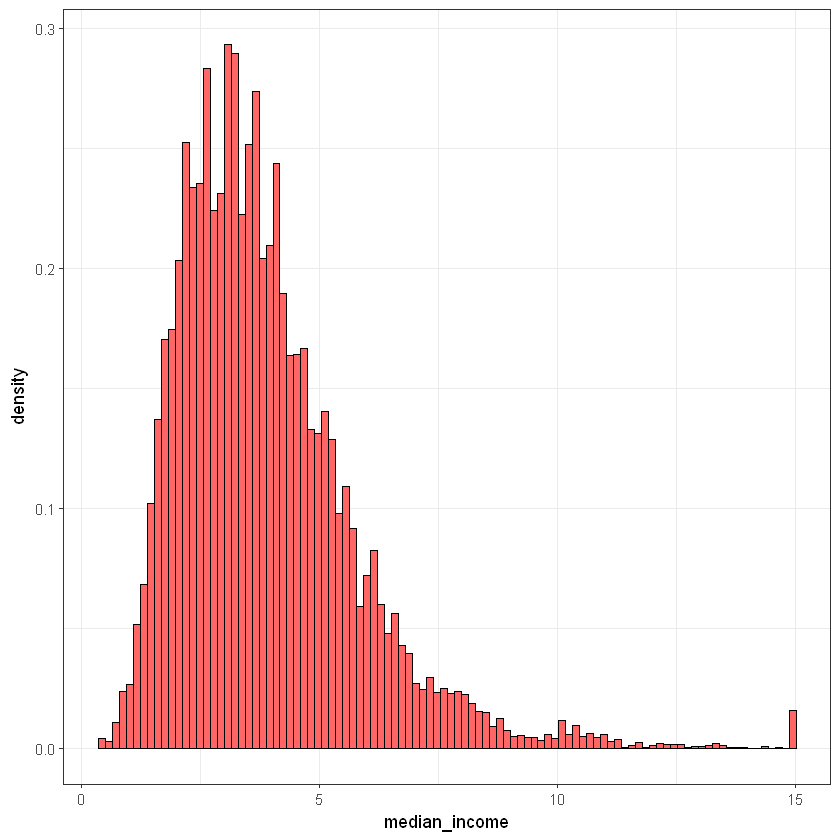

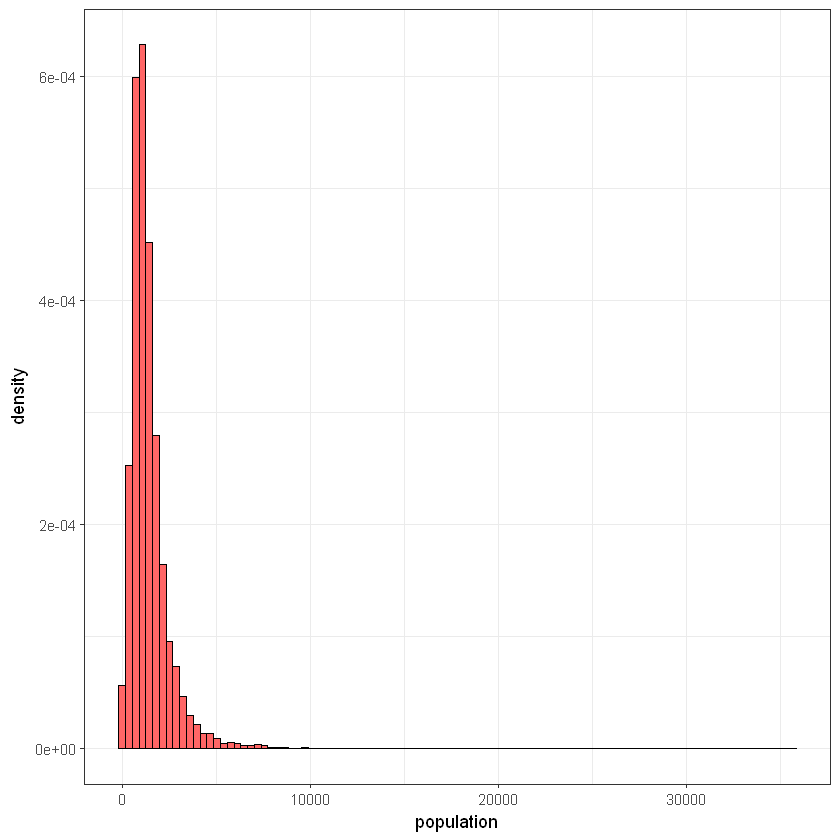

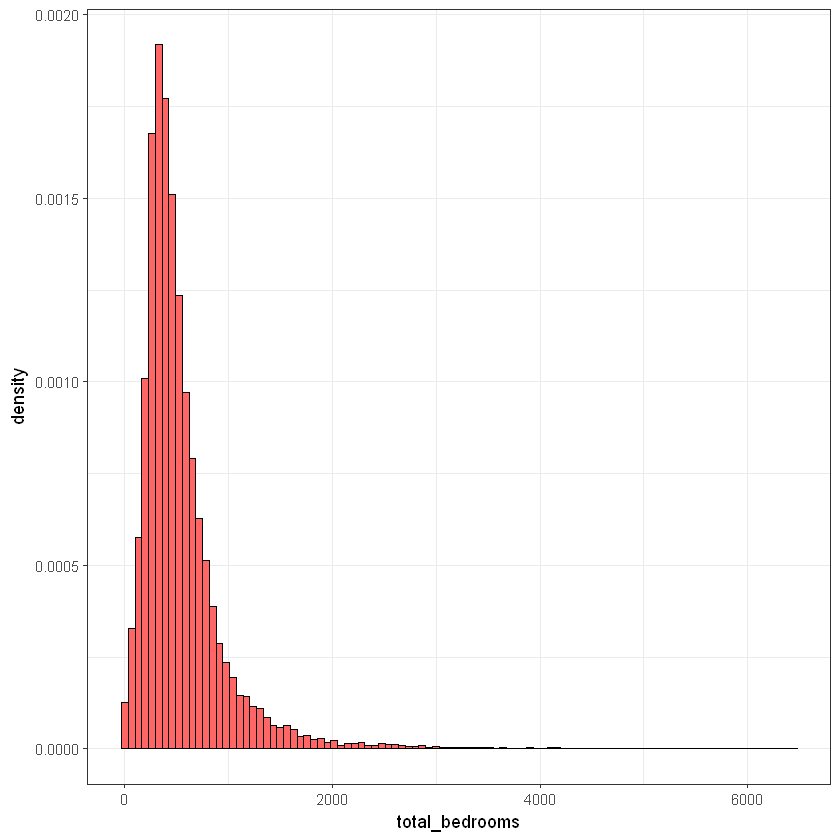

In [13]:
ggplot_histogram <- function(df, col, color="#FF6666") {
    print(
        ggplot(df, aes_string(x=col)) + 
         geom_histogram(aes(y=..density..), colour="black", fill=color, bins=100)
         
        )
}

interesting_cols = c('median_income', 'population', 'total_bedrooms')

for (col in interesting_cols) {
    ggplot_histogram(df_housing, col)
}

## Numeric Values &mdash; Normalization

$$x_{new} = \frac{x-x_{min}}{x_{max} - x_{min}}$$

In this example we use scikit-learn's `preprocessing.normalize` method to perform the normalization, but it would be just as easy to do this with vanilla numpy methods.

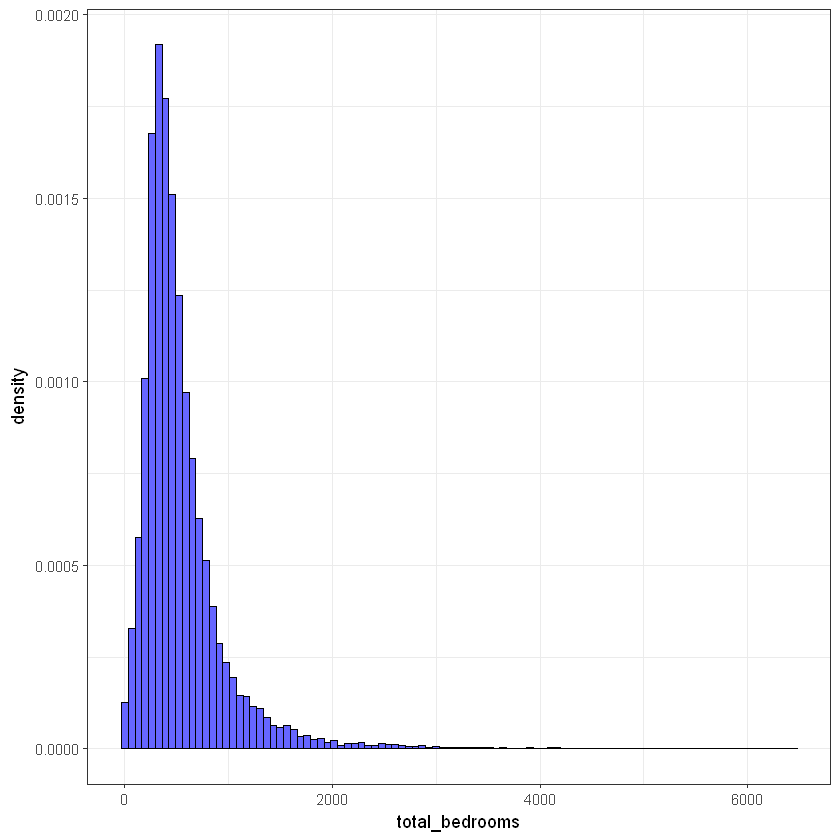

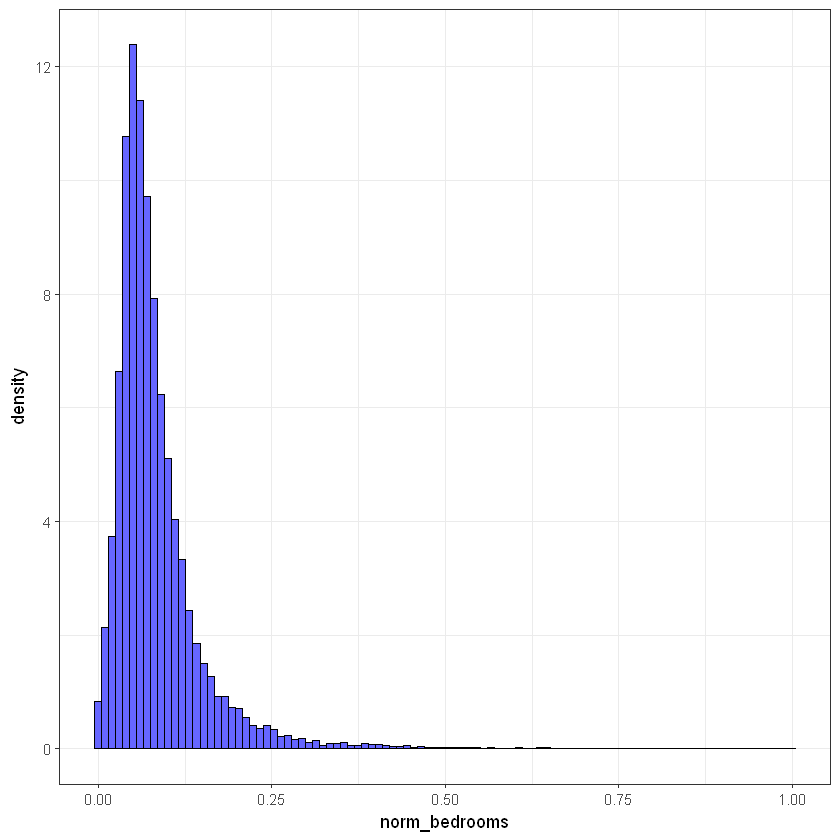

In [14]:
# Normalize total_bedrooms column
normalize <- function(x) {
    return ((x - min(x)) / (max(x) - min(x)))
  }

# Add as new column to our data.frame
df_housing$norm_bedrooms <- normalize(df_housing$total_bedrooms)

# Plot with with original
for (col in c('total_bedrooms', 'norm_bedrooms')) {
    ggplot_histogram(df_housing, col, color="#6666FF")
}

So we see the shape of the distribution is exactly the same, but the scale of the values is now constrained within $[0, 1]$.

## Numeric Values &mdash; Standardization

$$x_{new} = \frac{x-\mu}{\sigma}$$

Here, we'll simply use the Base R function `scale()` to calculate a new column to our DataFrame.

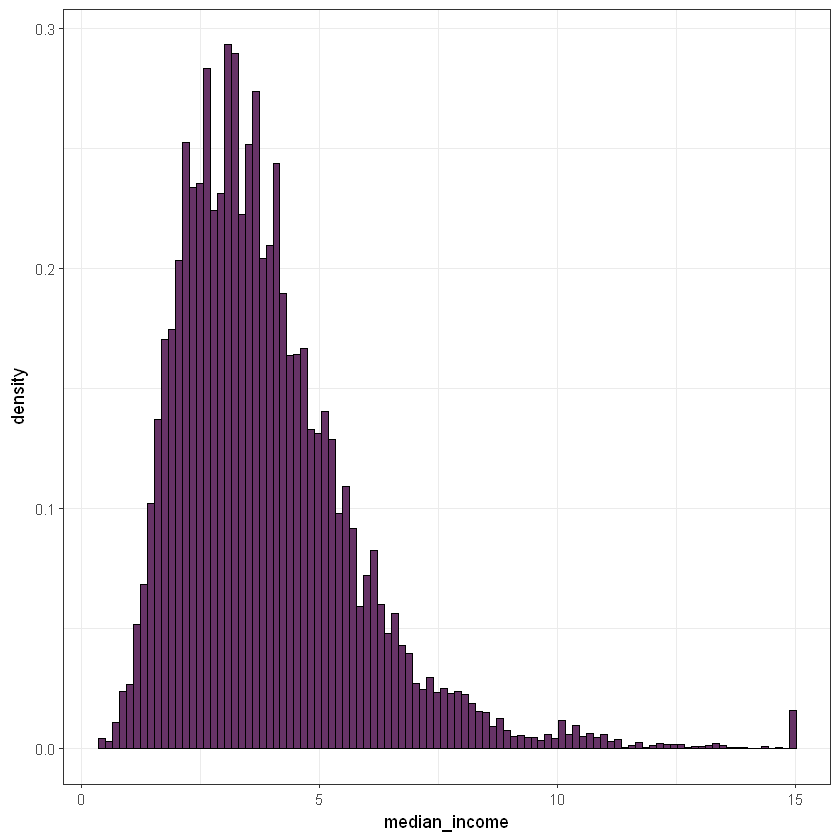

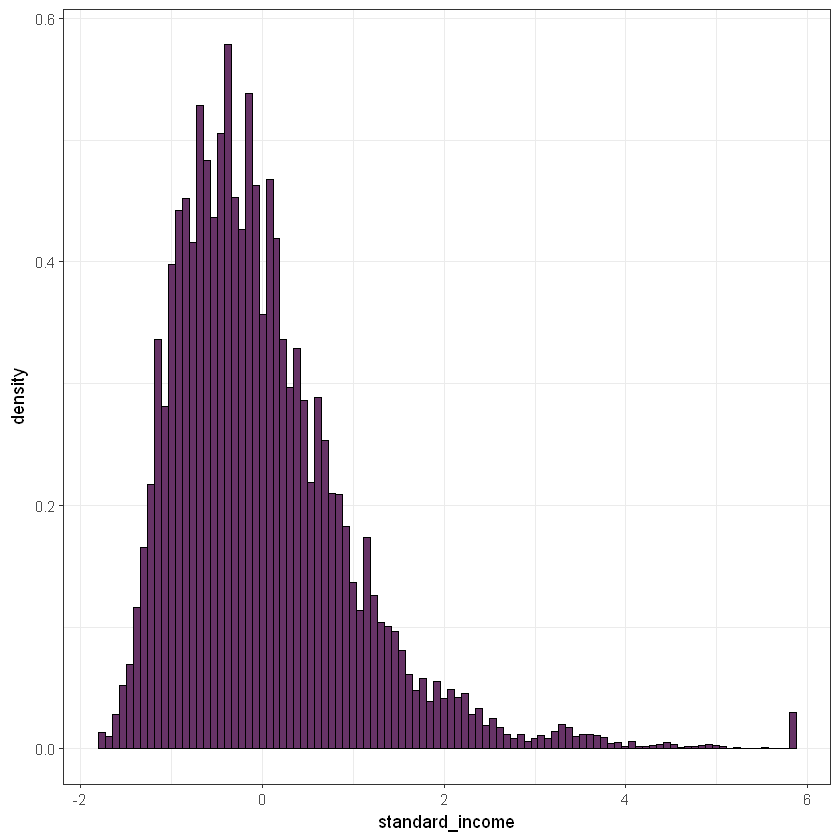

In [15]:
# Add as new column to our data.frame
df_housing$standard_income <- scale(df_housing$median_income)

# Plot with with original
for (col in c('median_income', 'standard_income')) {
    ggplot_histogram(df_housing, col, color="#663366")
}

Again, the shape of the distribution is exactly the same, but this time the mean of the distribution is at zero, and the unit value is equal to one standard deviation away from the mean.

## Numeric Values &mdash; Outliers

### Z-Score
This method uses the same function as for standardization, but uses the Z-score number as a threshold value that determines whether we keep that value or not. In this case, we decide to remove any value that is farther than 5 standard deviations away from the average.

Expert knowledge of the domain is sometimes required in order to set the threshold value.

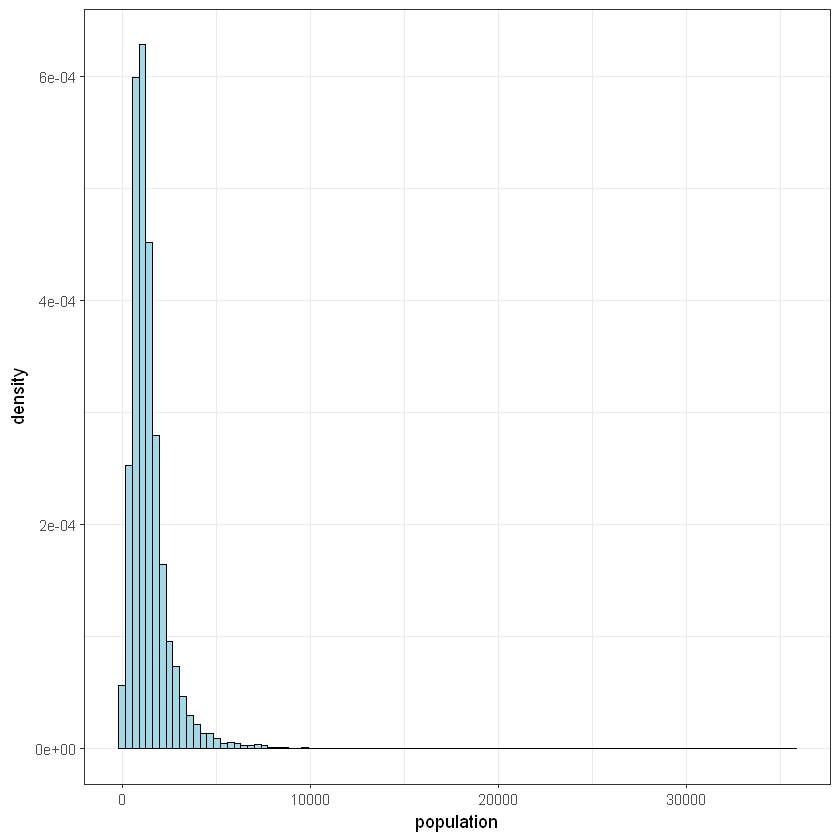

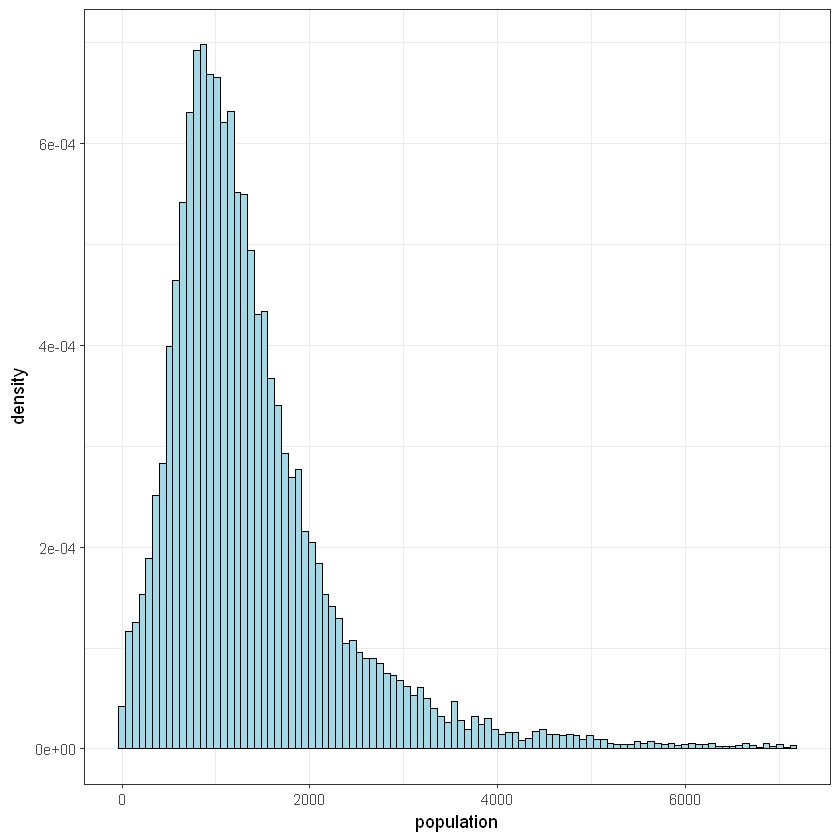

In [16]:
is_outlier <- function(x, threshold=5.0) {
    # Returns true if the value exceeds the threshold from distribution mean.
    # Default: 5 standard deviations.
    return(abs(scale(x)) < threshold)
}


# Plot the original
ggplot_histogram(df_housing, 'population', color="#A3D8E6")

# Plot the cleaned version
cleaned <- df_housing[is_outlier(df_housing$population),]
ggplot_histogram(cleaned, 'population', color="#A3D8E6")